In [5]:
# %initialize.m
# %% Initialize Parameters and special indices

import numpy as np 
import matplotlib.pyplot as plt

import logging
logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# global dt, Nb, N, h, rho, mu, ip, im, a;
# global kp, km, dtheta, K;

class IBM2(object):
  
  #### Fluid domain properties ####
    @property  # Number of grid cells
    def N(self): return self._N
    
    @N.setter
    def N(self, N):
        self._N = int(N)
        self._h = self.L/(self.N)
        self.ip = np.arange(N)+1   # Grid index shifted left
        self.ip[-1] = 0
        self.im = np.arange(N)-1   # Grid index shifted right
    
    @property  # Box size
    def L(self): return self._L
    
    @L.setter
    def L(self, L):
        self._L = float(L)
        self._h = self.L/self.N

    @property  # Grid spacing
    def h(self): return self._h
        
        
  #### Immersed Boundary domain roperties ####    
    @property  # Number of IB points
    def Nb(self): return self._Nb
    
    @Nb.setter 
    def Nb(self, Nb):
        self._Nb = int(Nb)
        self._dtheta = 2*np.pi/Nb        
        self.kp = np.arange(self.Nb)+1       # IB index shifted left
        self.kp[-1] = 0
        self.km = np.arange(self.Nb)-1       # IB index shifted right
    
    @property  # IB point spacing
    def dtheta(self): return self._dtheta
    def __init__(self, N=64, L=1., rho=1., mu=.01, Nb=None, K=1., dt=.01):
        self._L = L 
        self.N = N                         
        self.rho = rho  # Fluid density
        self.mu = mu    # viscosity 
        
        self.Nb = Nb or np.ceil(np.pi*(L)/(self.h)) 
        self.K = K      # Elastic stiffness
    

        self.dt = dt                    # Time step
    #     tmax=1 # Run until time
    #     clockmax=np.ceil(tmax/dt)
        
        self.init_a()
        self.initialize()
    
    def initialize(self):  ## Initialize boundary and velocity
        self.t = 0.        ## Current time
        N, L, ip, im, = self.N, self.L, self.ip, self.im
        print(self.ip)
        print(self.im)
        theta = self.dtheta*np.arange(self.Nb)
        self.X = (L/2) + (L/4)*np.array([np.cos(theta), np.sin(theta)])
        self.X = np.array(self.X, dtype=np.float64)
        print('X:')
        print(self.X)
        u = np.zeros([2,N,N]);
        j = np.arange(N)
        u[1]+=np.sin(2*np.pi*self.h*j/L)
        u[0]+=np.cos(2*np.pi*self.h*j/L)
        u[1] = np.transpose(u[1])
        u[0] = np.transpose(u[0])
#         print('u:')
#         print(u)
#         print('u[0,:,0]')
#         print(u[0,:,0])
#         print('u[0,:,1]')
#         print(u[0,0,:])
#         print('skew(u):')
#         print(self.skew(u))
#         u[:,:,1]+=np.sin(2*np.pi*j*self.h/L)[:, np.newaxis];
        self.u = u

    
#         print('LAPLACIAN')
#         print(self.laplacian(u))
#         print('SKEW')
#         print(self.skew(u))
#         ii = np.meshgrid(ip, np.arange(N))
#         print('uxpx:')
#         print(u[0][ip,:]) 
#         print((u[0][ip,:]==u[0]))
#         print('uxmx:')
#         print(u[0,im,:]) 
#         print('uxpy:')
#         print(u[0,:,ip]) 
#         print('uxmy:')
#         print(u[0,:,im])
    
    
#         print('t1:')
#         print((u[0,:,ip]+u[0])*u[0,:,ip]) 
#         print('t2:')
#         print((u[0,:,im]+u[0])*u[0,:,im]) 
#         print('t3:')
#         print((u[1,ip,:]+u[1])*u[0,ip,:]) 
#         print('t4:')
#         print((u[1,im,:]+u[1])*u[0,im,:])
#         print((u[0][ii]+u[0])*u[0][ii])



#         print('-------------')
#         print()
#         print()
#         print()
        # %% Initialize animation
        vorticity=(u[1,ip,:]-u[1,im,:]-u[0,:,ip]+u[0,:,im])/(2*self.h);
        dvorticity=(np.max(vorticity)-np.min(vorticity))/5;
        dvorticity = max(dvorticity, 0.1)  ## Catch error on 0 (or uniform) vorticity
        # values= (-10*dvorticity):dvorticity:(10*dvorticity); % Get vorticity contours
        values= np.arange(-10*dvorticity, 10*dvorticity, dvorticity); # Get vorticity contours
        valminmax=[min(values),max(values)];
    

    #     set(gcf,'double','on')
        plt.figure(figsize=(8,8))
#         plt.contour(xgrid,ygrid,vorticity,values)
        plt.imshow(u[1])
        plt.show()
        plt.figure(figsize=(8,8))
        plt.scatter(self.X[0],self.X[1])
        plt.xlim([0,L])
        plt.ylim([0,L])
        plt.show()


    def init_a(self):
        N = self.N
        a = np.zeros([2,2,N,N])#, dtype=np.complex)#, dtype=np.complex128)
        a[0, 0] = 1
        a[1, 1] = 1

        for m1 in range(N):
            for m2 in range(N):
                if not ((m1==0 or (N%2==0 and m1==int(N/2))) and (m2==0 or m2==(N%2==0 and int(N/2)))):
                    t=(2*np.pi/N)*np.array([m1, m2]);
                    s=np.sin(t);

                    #### Note matrix multiplication might matter here
                    ss=np.outer(s, s)/np.inner(s, s)

                    #     a(m1+1,m2+1,:,:)=a(m1+1,m2+1,:,:)-(s*s')/(s'*s)
                    a[0,0,m1,m2]-=ss[0,0]
                    a[0,1,m1,m2]-=ss[0,1]
                    a[1,0,m1,m2]-=ss[1,0]
                    a[1,1,m1,m2]-=ss[1,1]

        for m1 in range(N):
            for m2 in range(N):
                t=(np.pi/N)*np.array([m1, m2]);
                s=np.sin(t);
                a[:,:,m1,m2] /= (1+(self.dt/2)*(self.mu/self.rho)*(4/(self.h**2))*(np.inner(s, s)));
        self.a = a

   
    
  
    
    def phi(self, r):
        w = np.zeros(4)
        q=np.sqrt(1+4*r*(1-r))
        w[3]=(1+2*r-q)/8
        w[2]=(1+2*r+q)/8
        w[1]=(3-2*r+q)/8
        w[0]=(3-2*r-q)/8
        return w

    def interp(self, u, X):
        N, Nb, h = self.N, self.Nb, self.h
        W = np.zeros([N, N])

        U=np.zeros([2,Nb])
        s=X/float(h)
        i=np.array(np.floor(s), dtype=int)
        r=s-i
        logger.debug('INTERP')
        logger.debug('r')
        logger.debug(r)
        for k in range(Nb):
            w = np.outer(self.phi(r[1, k]), self.phi(r[0, k]))
            logger.debug('w_{}'.format(k))
            logger.debug(w)
          
#             w = np.outer(self.phi(r[0, k]), np.flip(self.phi(r[1, k])))
            i1 = np.arange(i[0,k]-1, i[0,k]+3)%N
            i2 = np.arange(i[1,k]-1, i[1,k]+3)%N
            ii = np.meshgrid(i1, i2)
            logger.debug('ii_{}'.format(ii))
            logger.debug(ii)
            logger.debug('u[ii]')
            logger.debug(u[0][ii])
            logger.debug(u[1][ii])
            logger.debug('')

            W[ii] += w
            U[0,k]=np.sum(w*u[0][ii]);
            U[1,k]=np.sum(w*u[1][ii]);
#         print('after interp:')
        
#         plt.imshow(np.transpose(W))
#         plt.colorbar()
#         plt.scatter(X[0]/h, X[1]/h)
#         plt.show()
#         print(np.mean(abs(U)))
        logger.debug('U')
        logger.debug(U)
        logger.debug('-----------')
        return U
    
    def vec_spread(self, F, X):
        N, Nb, h = self.N, self.Nb, self.h
        W = np.zeros([N, N])
        
        c=self.dtheta/h**2;
        f=np.zeros([2,N,N]);
        s=X/float(h)
        i=np.array(np.floor(s), dtype=int)
        r=s-i
        logger.debug('SPREAD')
        logger.debug('r')
        logger.debug(r)        
#         print('SPREAD')
#         print('r')
#         print(r)
#         w=self.phi1(r[0])*self.phi2(r[1]);
#         print(np.shape(w))
        for k in range(Nb):
#             w = np.outer(self.phi(r[0, k]), np.flip(self.phi(r[1, k])))
            w = np.outer(self.phi(r[1, k]), self.phi(r[0, k]))
            logger.debug('w_{}'.format(k))
            logger.debug(w)
          
            i1 = np.arange(i[0,k]-1, i[0,k]+3)%N
            i2 = np.arange(i[1,k]-1, i[1,k]+3)%N
            ii = np.meshgrid(i1, i2)
#             print(i1)
#             print(i2)
            logger.debug('ii_{}'.format(ii))
            logger.debug(ii)
            
            f[0][ii]+=(c*F[0,k])*w #Spread force to fluid
            f[1][ii]+=(c*F[1,k])*w
            W[ii] += w#[k]
            logger.debug('f[ii]')
            logger.debug(f[0][ii])
            logger.debug(f[1][ii])
            logger.debug('')
                       
#         print('after spread:')
#         plt.imshow(np.transpose(W))
#         plt.colorbar()
#         plt.scatter(X[0]/h, X[1]/h)
#         plt.show()
        return f 
    
    
    # elastic stretching force
    def Force(self, X):
        kp, km, dtheta, K = self.kp, self.km, self.dtheta, self.K
        return K*(X[:,kp]+X[:,km]-2*X)/(dtheta**2);
    
    
    # Time step the fluid
    def fluid(self, u, ff):
        
        uu = np.zeros(np.shape(u), dtype=np.complex)
        uuu = np.zeros(np.shape(u), dtype=np.complex)
        
        a, dt, rho, mu = self.a, self.dt, self.rho, self.mu
        w=u-(dt/2)*self.skew(u)+(dt/(2*rho))*ff; # Get RHS
#         print('w:')
#         print(w)
        w=np.fft.fft(w, axis=1)
        w=np.fft.fft(w, axis=2)
#         print('w_hat:')
#         print(w)
        uu[0]=a[0,0]*w[0]+a[0,1]*w[1]; # Solve for LHS
        uu[1]=a[1,0]*w[0]+a[1,1]*w[1];
#         print('uu_hat:')
#         print(uu)
        uu=np.fft.ifft(uu,axis=2);
        uu=np.fft.ifft(uu,axis=1).real; #Get u at midpoint in time
#         print('uu:')
#         print(uu)
        
        
        w=u-dt*self.skew(uu)+(dt/rho)*ff+(dt/2)*(mu/rho)*self.laplacian(u);# Get RHS
#         print('w2:')
#         print(w)
        w=np.fft.fft(w, axis=1)
        w=np.fft.fft(w, axis=2)
        uuu[0]=a[0,0]*w[0]+a[0,1]*w[1];# Solve for LHS
        uuu[1]=a[1,0]*w[0]+a[1,1]*w[1];
       
        uuu=np.fft.ifft(uuu,axis=2);
        uuu=np.fft.ifft(uuu,axis=1).real; # Get u at next timestep
        return uuu, uu

    # Second order centered Laplacian
    def laplacian(self, u): 
        im, ip, h = self.ip, self.im, self.h
        w=(u[:,ip,:]+u[:,im,:]+u[:,:,ip]+u[:,:,im]-4*u)/(h**2);
        return w
    #     % im = [N,1:(N-1)] = circular version of i-1
    #     % ip = [2:N,1]     = circular version of i+1
    #     % N  = number of points in each space direction
    
    
    def skew(self, u):
        w=u*.1; #note that this is done only to make w the same size as u
        w[0]=self.sk(u,u[0]);
        w[1]=self.sk(u,u[1]);
        return w
    
    
    def sk(self, u, g):
        ip, im, h = self.ip, self.im, self.h
        return ((u[0,ip,:]+u[0])*g[ip,:]
                -(u[0,im,:]+u[0])*g[im,:]
                +(u[1,:,ip]+u[1])*g[:,ip]
                -(u[1,:,im]+u[1])*g[:,im])/(4*h);
#     def skew(self, u):
#         w=u.copy(); #note that this is done only to make w the same size as u
#         ip, im, h = self.ip, self.im, self.h
#         w[0]=((u[0,ip,:]+u[0])*u[0,ip,:]
#                 -(u[0,im,:]+u[0])*u[0,im,:]
#                 +(u[1,:,ip]+u[1])*u[0,:,ip]
#                 -(u[1,:,im]+u[1])*u[0,:,im])/(4*h);
#         w[1]=((u[0,ip,:]+u[0])*u[1,ip,:]
#                 -(u[0,im,:]+u[0])*u[1,im,:]
#                 +(u[1,:,ip]+u[1])*u[1,:,ip]
#                 -(u[1,:,im]+u[1])*u[1,:,im])/(4*h);
#         return w
    
    
    
#     def skew(self, u):
#         w=u.copy(); #note that this is done only to make w the same size as u
#         ip, im, h = self.ip, self.im, self.h
#         w[0]=((u[0,:,ip]+u[0])*u[0,:,ip]
#                 -(u[0,:,im]+u[0])*u[0,:,im]
#                 +(u[1,ip,:]+u[1])*u[0,ip,:]
#                 -(u[1,im,:]+u[1])*u[0,im,:])/(4*h);
#         w[1]=((u[0,:,ip]+u[0])*u[1,:,ip]
#                 -(u[0,:,im]+u[0])*u[1,:,im]
#                 +(u[1,ip,:]+u[1])*u[1,ip,:]
#                 -(u[1,im,:]+u[1])*u[1,im,:])/(4*h);
#         return w

#     def skew(self, u):
#         w=u.copy(); #note that this is done only to make w the same size as u
#         ip, im, h = self.ip, self.im, self.h
#         w[0]=((u[0,ip,:]-u[0,im,:])*u[0] + (u[0,:,ip]-u[0,:,im])*u[1])/(2*h)
#         w[1]=((u[1,ip,:]-u[1,im,:])*u[0] + (u[1,:,ip]-u[1,:,im])*u[1])/(2*h)
#         return w
    
    
#     def sk(self, u, g):
#         ip, im, h = self.ip, self.im, self.h
#         return ((u[0,ip,:]+u[0])*g[ip,:]
#                 -(u[0,im,:]+u[0])*g[im,:]
#                 +(u[1,:,ip]+u[1])*g[:,ip]
#                 -(u[1,:,im]+u[1])*g[:,im])/(4*h);
   ## Run until time t
    def run(self, t):
        while self.t < t:         #for clock=1:clockmax
            self.iterate()

    def iterate(self):
        dt = self.dt
        ## Run simulation
        self.t += dt
        XX=self.X+(dt/2)*self.interp(self.u,self.X) # Euler step to midpoint
#         print('XX')
#         print(XX)
#         print('Force(XX)')
#         print(self.Force(XX))
        ff=self.vec_spread(self.Force(XX),XX) # Force at midpoint
#         print('ff')
#         print(ff)
#         print('u before fluid')
#         print(self.u)
        u,uu=self.fluid(self.u,ff) # Step Fluid Velocity
        
#         print('u after fluid')
#         print(u)
        self.X+=dt*self.interp(uu,XX) # full step using midpoint velocity
#         print('X')
#         print(self.X)
#         print()
#         print()
#         print(np.mean(abs(dt*self.interp(uu,XX))))
        self.u = u

        #animation:        
#         ip, im = self.ip, self.im
#         vorticity=(u[1,ip,:]-u[1,im,:]-u[0,:,ip]+u[0,:,im])/(2*self.h);
# #         plt.contour(xgrid,ygrid,vorticity,values)
#         plt.imshow(vorticity)
#         plt.colorbar()
#         plt.streamplot(*np.meshgrid(np.arange(self.N), np.arange(self.N)), self.u[0], self.u[1])
#         plt.show()
        plt.scatter(self.X[0],self.X[1])
        plt.xlim([0,self.L])
        plt.ylim([0,self.L])

    #     caxis(valminmax)
    #     axis equal
    #     axis manual
        plt.show()
#         self.u[0, :] = 0.5

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63  0]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
X:
[[0.75       0.74987907 0.7495164  0.74891234 0.74806747 0.74698261
  0.74565881 0.74409736 0.74229975 0.74026774 0.73800328 0.73550857
  0.73278602 0.72983826 0.72666815 0.72327875 0.71967335 0.71585543
  0.71182868 0.707597   0.70316448 0.69853541 0.69371428 0.68870573
  0.68351463 0.67814599 0.67260501 0.66689704 0.6610276  0.65500239
  0.64882722 0.64250806 0.63605105 0.62946241 0.62274852 0.61591588
  0.6089711  0.6019209  0.5947721  0.58753161 0.58020644 0.57280368
  0.56533048 0.55779408 0.55020177 0.54256089 0.53487883 0.52716304
  0.51942096 0.5116601  0.50388795 0.49611205 0.4883399  0.48

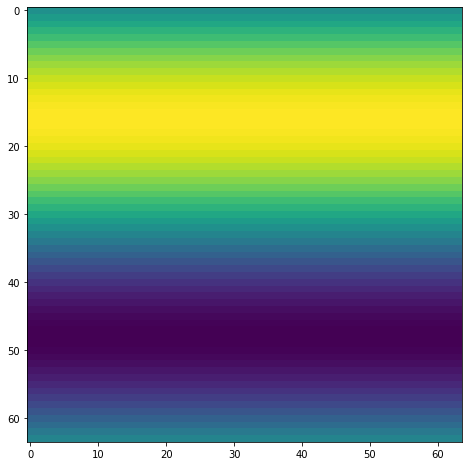

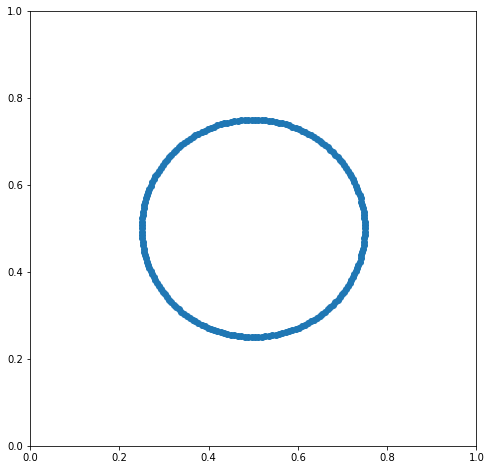

<ipython-input-5-8356cf7cfb7c>:217: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  logger.debug(u[0][ii])
<ipython-input-5-8356cf7cfb7c>:218: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  logger.debug(u[1][ii])
<ipython-input-5-8356cf7cfb7c>:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  W[ii] += w
<ipython-inpu

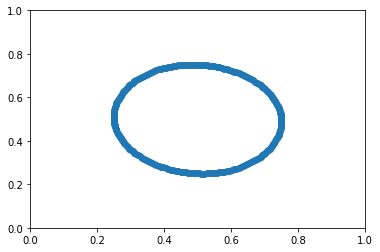

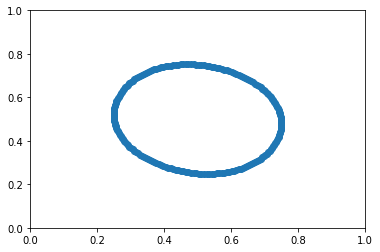

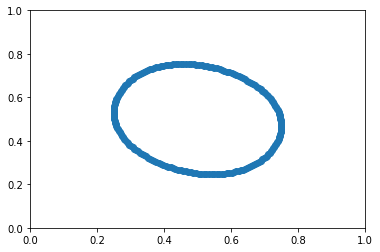

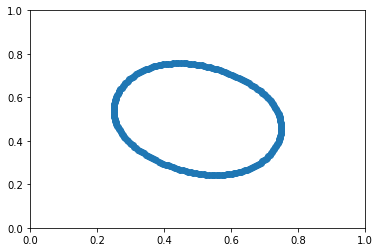

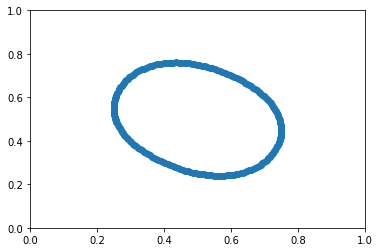

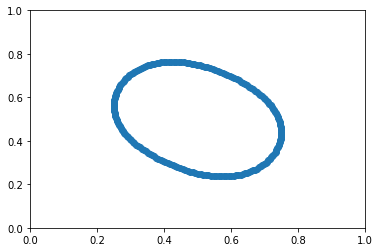

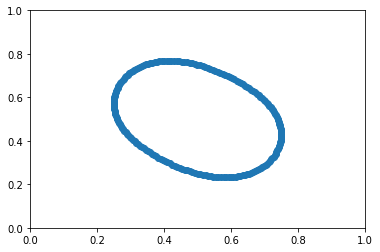

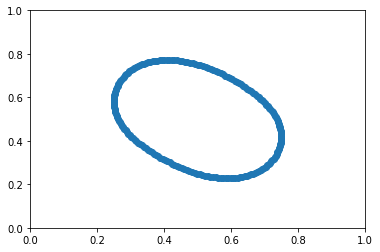

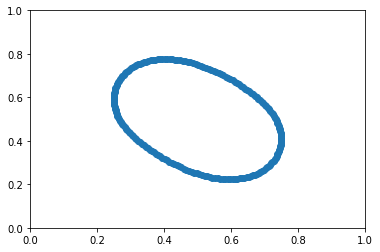

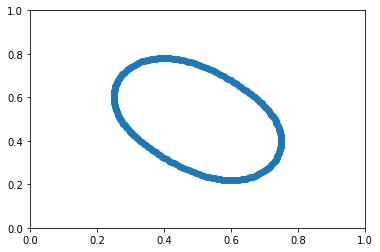

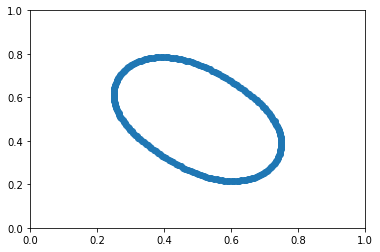

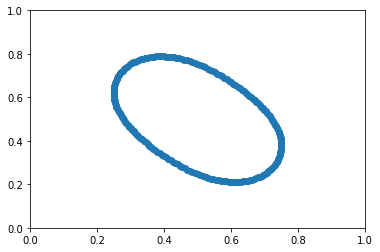

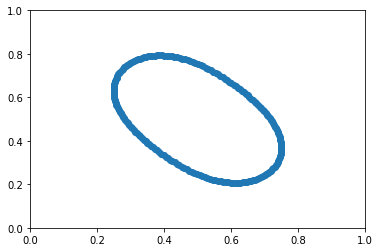

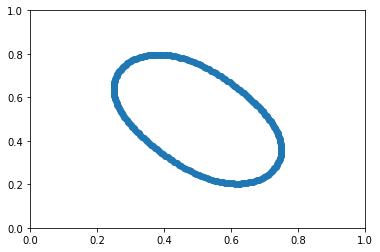

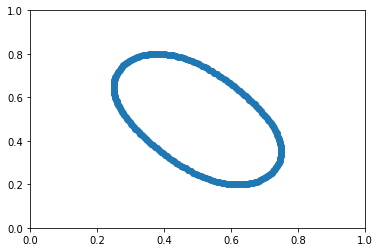

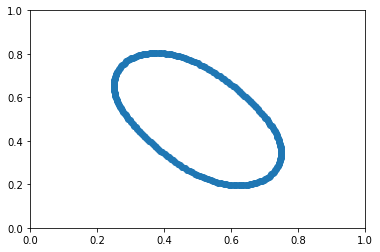

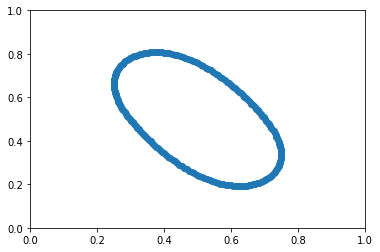

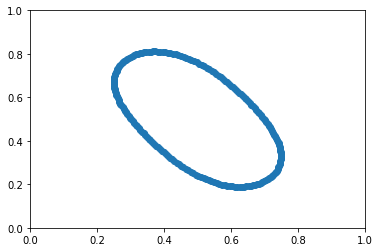

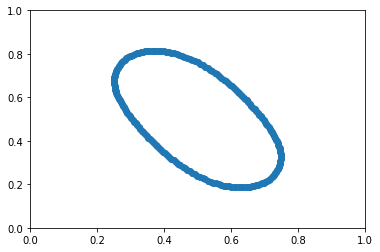

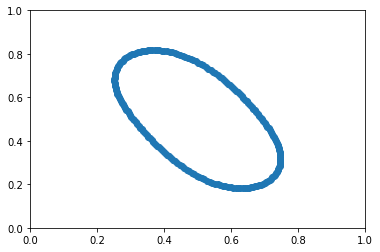

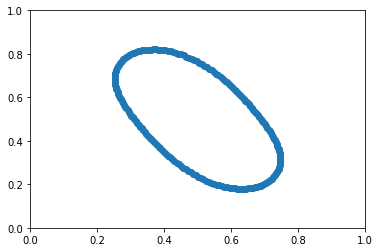

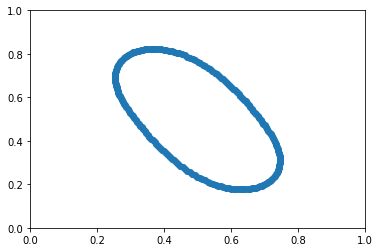

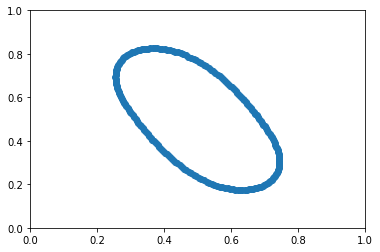

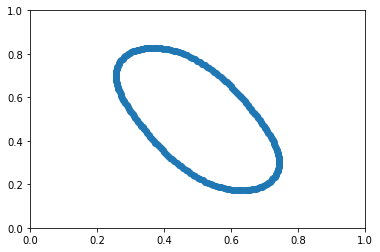

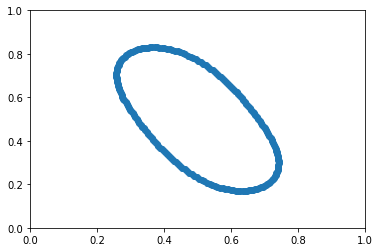

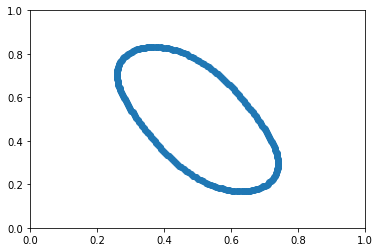

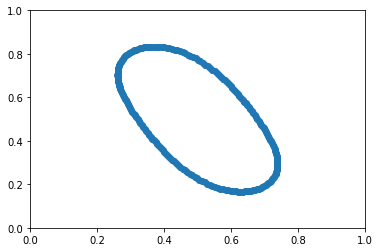

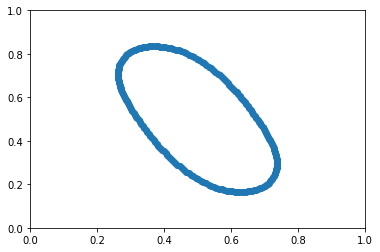

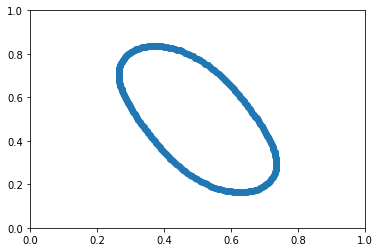

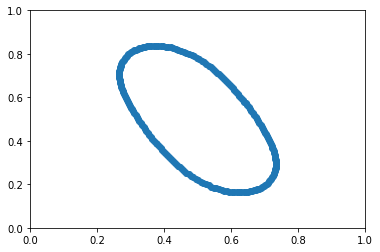

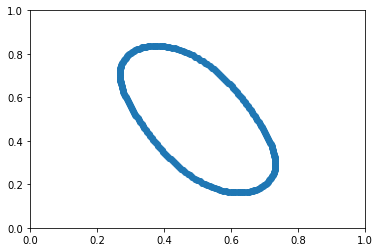

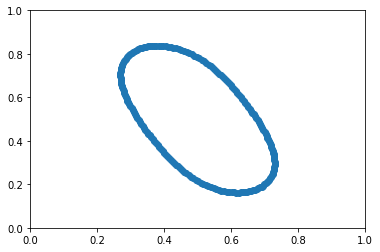

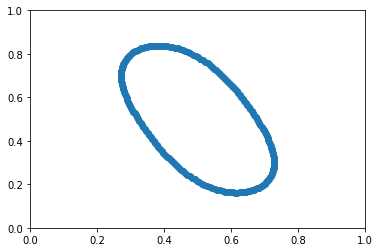

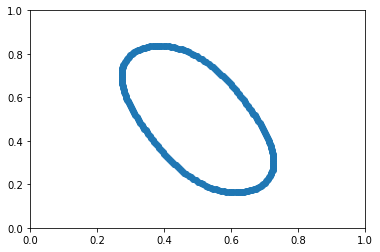

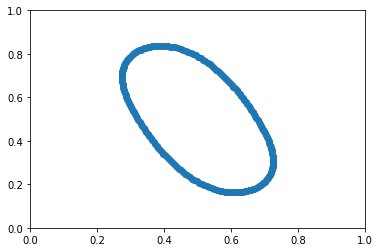

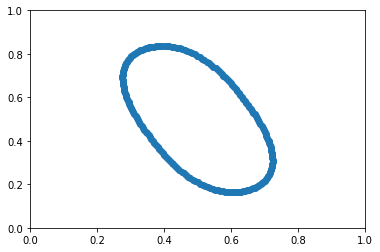

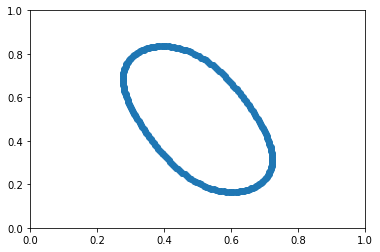

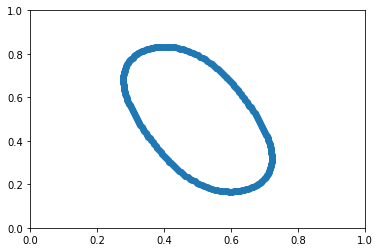

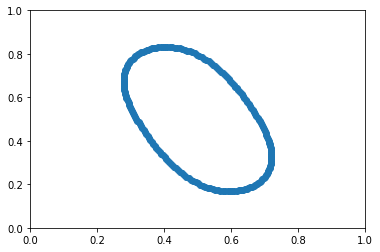

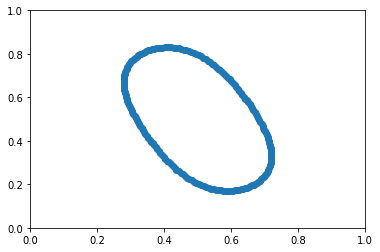

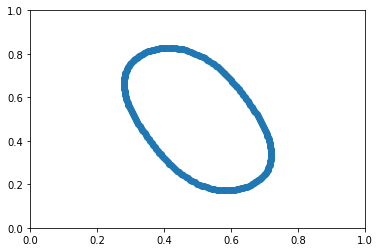

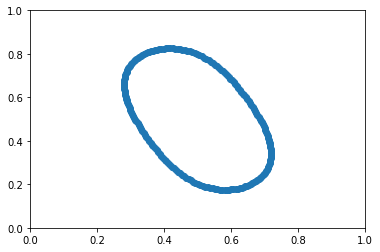

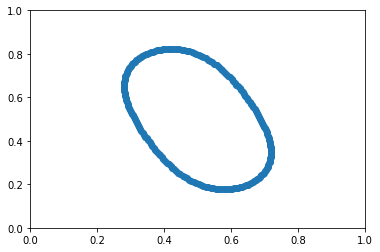

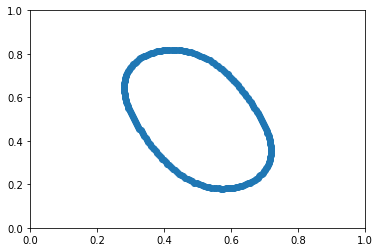

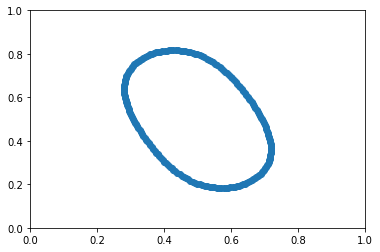

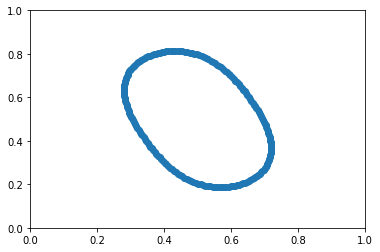

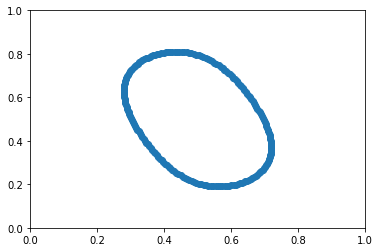

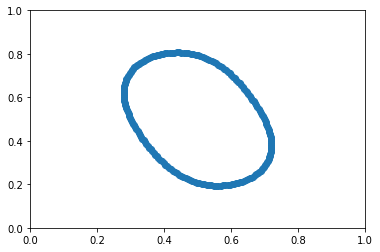

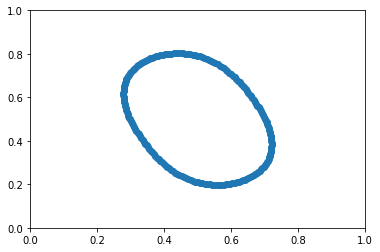

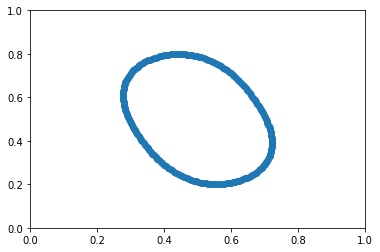

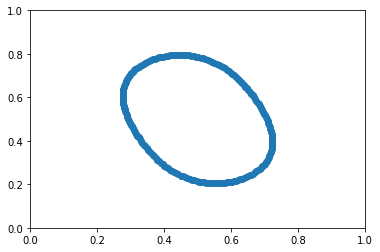

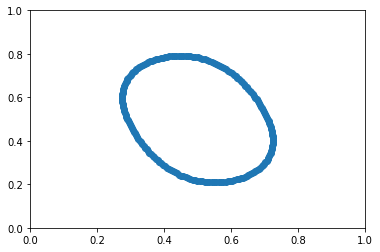

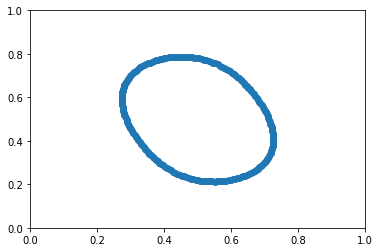

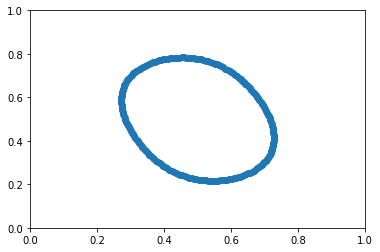

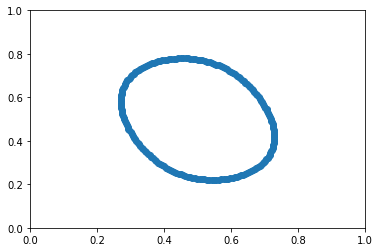

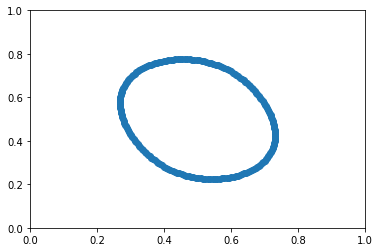

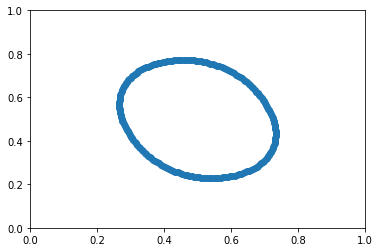

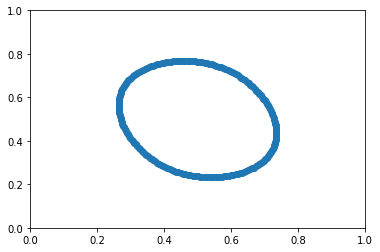

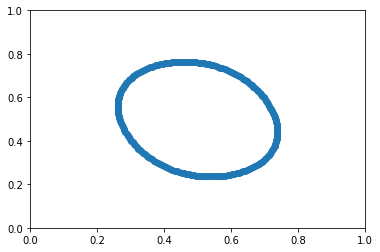

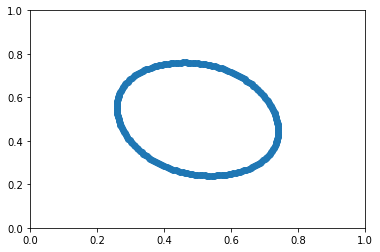

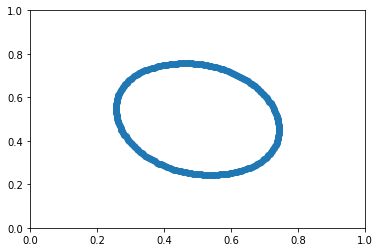

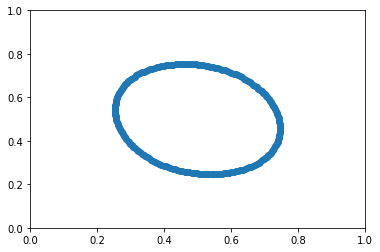

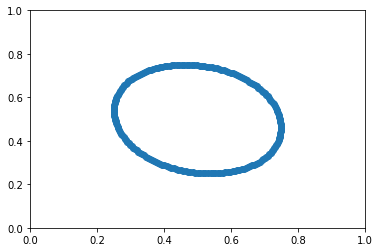

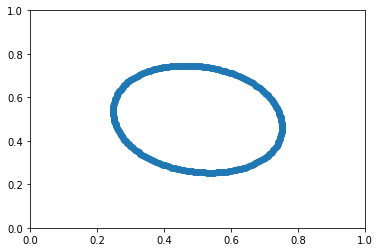

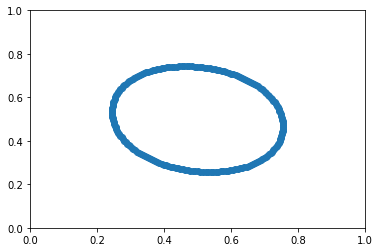

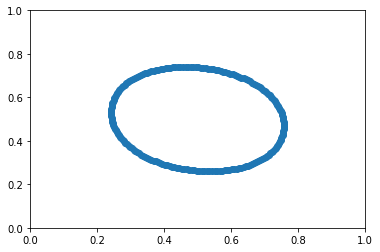

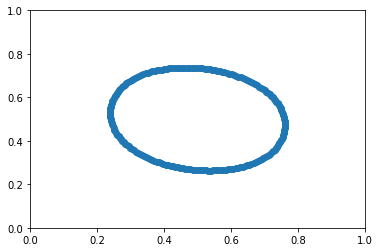

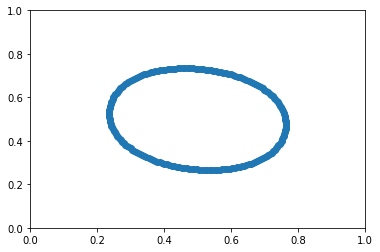

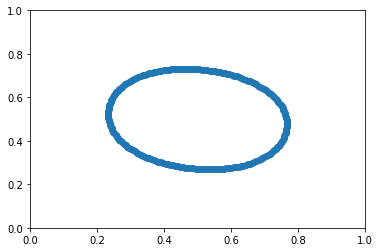

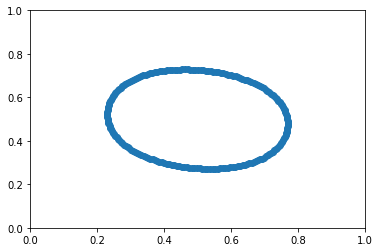

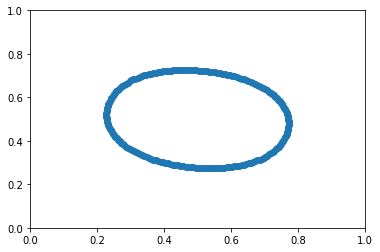

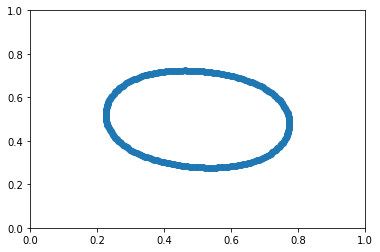

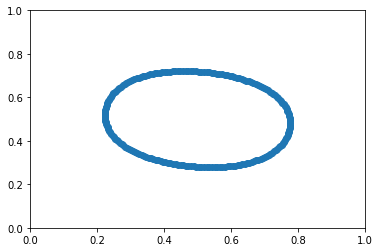

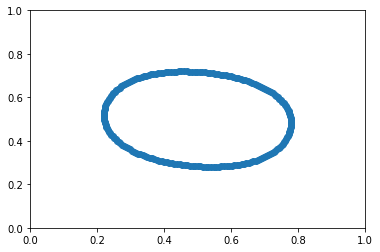

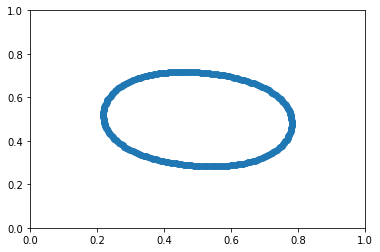

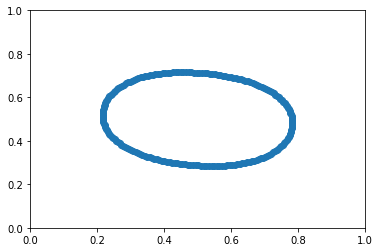

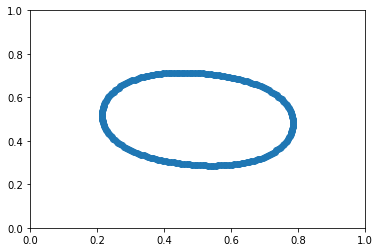

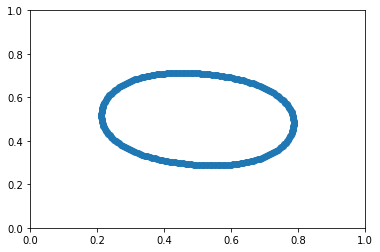

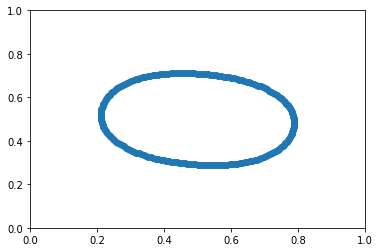

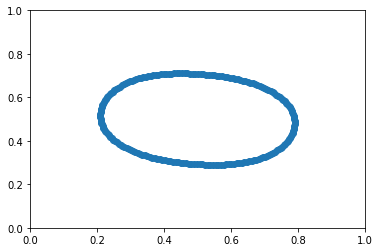

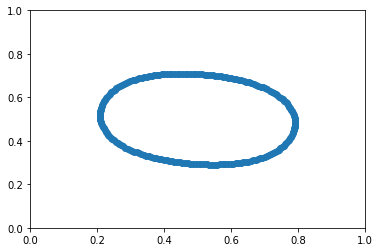

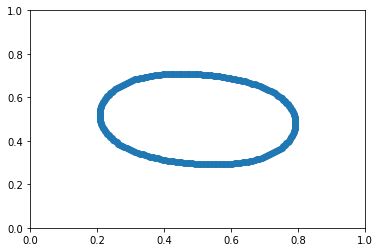

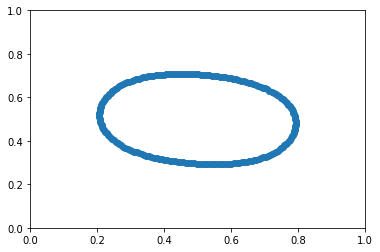

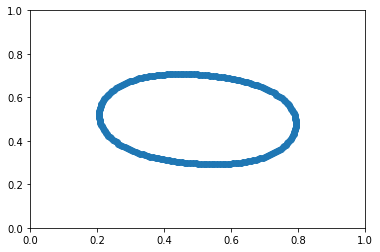

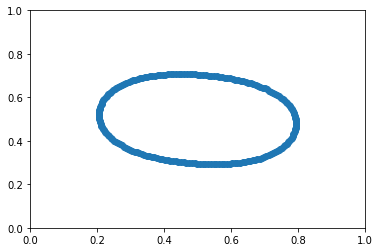

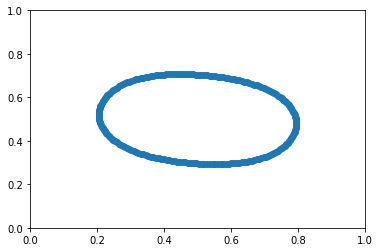

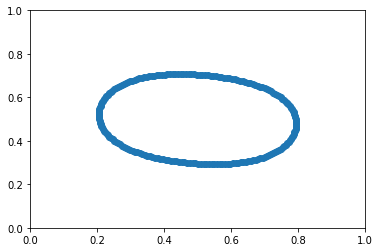

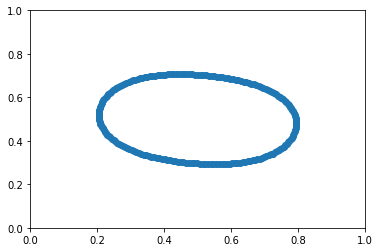

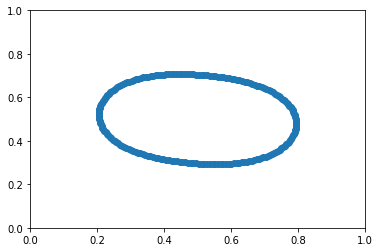

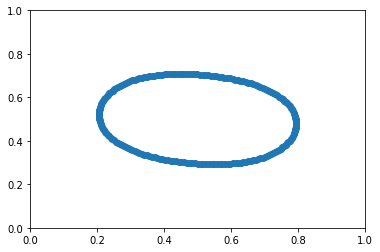

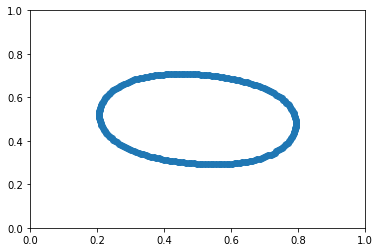

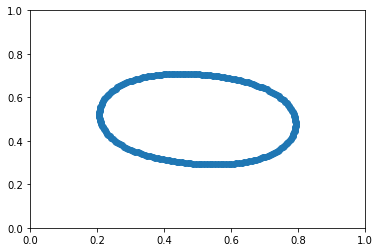

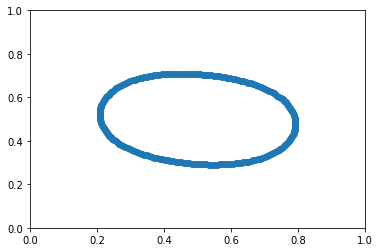

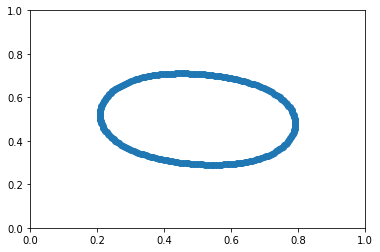

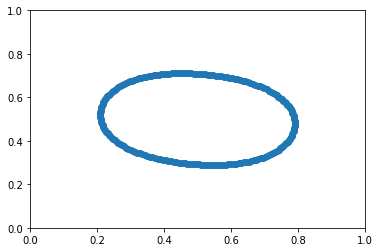

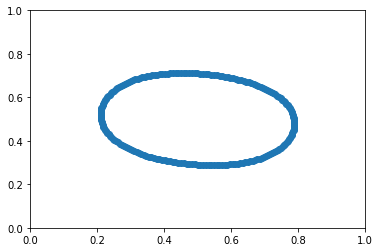

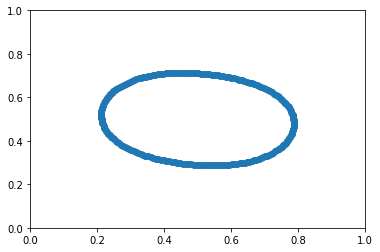

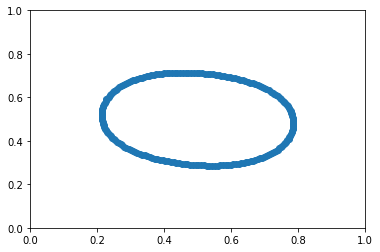

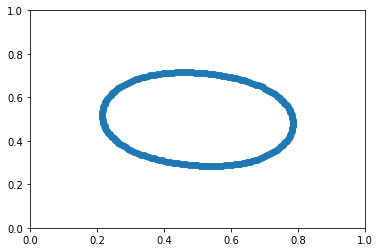

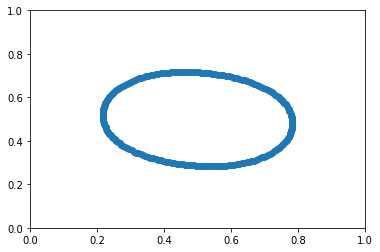

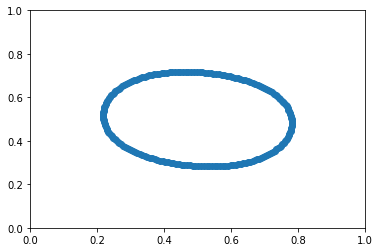

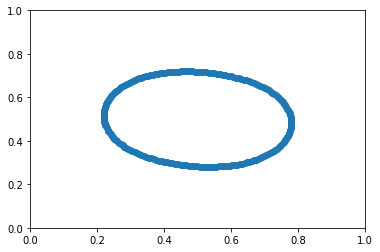

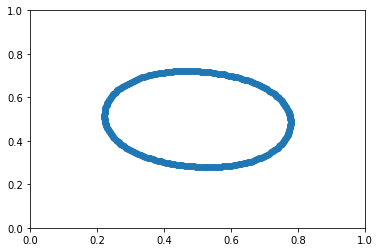

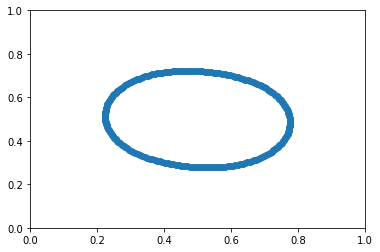

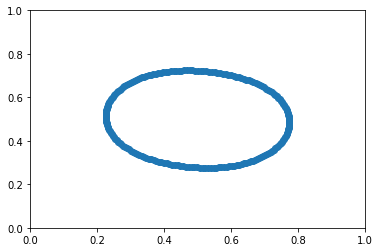

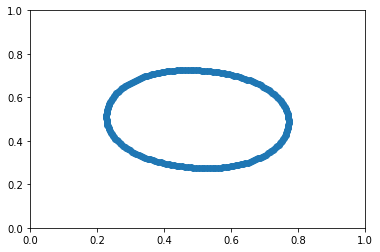

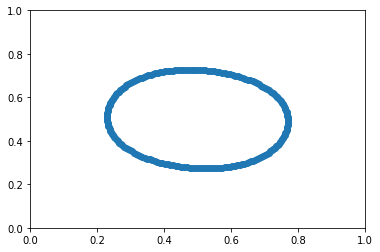

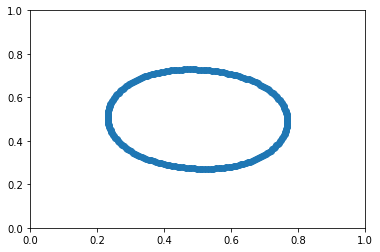

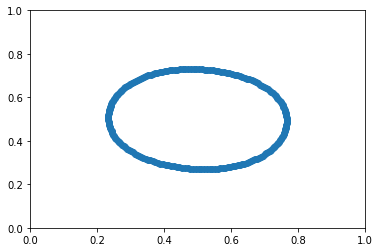

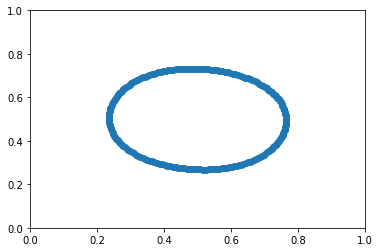

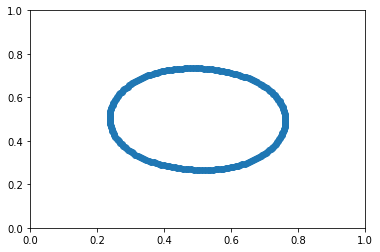

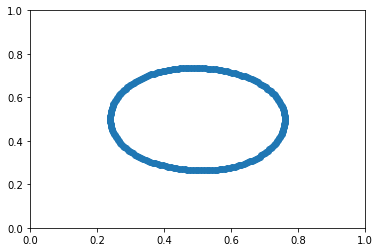

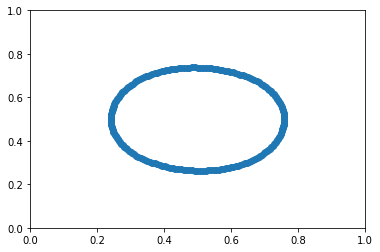

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [6]:
sim = IBM2()
# sim = IBM2(N=5, Nb=4)
# r = np.linspace(-5., 5., 100)
# plt.imshow(sim.vec_phi1(r))
# plt.colorbar()
# plt.show()
for i in range(250):
    sim.iterate()
# sim.run(.5)

[9 8 7 6 5 4 3 2 1 0]


In [56]:
print(sim.dtheta)
print(sim.h)

1.5707963267948966
0.2


In [25]:
x = np.arange(5)+1
y = 2*np.arange(5)+3
m = np.outer(x, y)
print(m)

[[ 3  5  7  9 11]
 [ 6 10 14 18 22]
 [ 9 15 21 27 33]
 [12 20 28 36 44]
 [15 25 35 45 55]]


In [29]:
ix = x-1
ix
print(m[:, ix-1])

[[11  3  5  7  9]
 [22  6 10 14 18]
 [33  9 15 21 27]
 [44 12 20 28 36]
 [55 15 25 35 45]]


In [110]:
print(sim.a)

[[[[ 1.        +0.j  0.99827552+0.j  0.99549782+0.j  0.99549782+0.j
     0.99827552+0.j]
   [ 0.        +0.j  0.49827849+0.j  0.27467647+0.j  0.27467647+0.j
     0.49827849+0.j]
   [ 0.        +0.j  0.71911235+0.j  0.495518  +0.j  0.495518  +0.j
     0.71911235+0.j]
   [ 0.        +0.j  0.71911235+0.j  0.495518  +0.j  0.495518  +0.j
     0.71911235+0.j]
   [ 0.        +0.j  0.49827849+0.j  0.27467647+0.j  0.27467647+0.j
     0.49827849+0.j]]

  [[ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
     0.        +0.j]
   [ 0.        +0.j -0.49827849+0.j -0.44443587+0.j  0.44443587+0.j
     0.49827849+0.j]
   [ 0.        +0.j -0.44443587+0.j -0.495518  +0.j  0.495518  +0.j
     0.44443587+0.j]
   [ 0.        +0.j  0.44443587+0.j  0.495518  +0.j -0.495518  +0.j
    -0.44443587+0.j]
   [ 0.        +0.j  0.49827849+0.j  0.44443587+0.j -0.44443587+0.j
    -0.49827849+0.j]]]


 [[[ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
     0.        +0.j]
   [ 0.        

In [72]:
a = np.array([0.1, 3.1, 4.2, 8])
b = np.array([4.9, 6.2, 8.3, 9.1])
print(np.outer(a, b))
print(np.inner(a, b))
print(np.outer(a, b)/np.inner(a, b))

[[ 0.49  0.62  0.83  0.91]
 [15.19 19.22 25.73 28.21]
 [20.58 26.04 34.86 38.22]
 [39.2  49.6  66.4  72.8 ]]
127.37
[[0.00384706 0.00486771 0.00651645 0.00714454]
 [0.11925885 0.15089896 0.20200989 0.22148073]
 [0.16157651 0.20444375 0.27369082 0.30007066]
 [0.30776478 0.38941666 0.52131585 0.57156316]]
